# Linear Regression:

Linear regression is about predicting a <I>real valued target</I> $y$ given a data point $x$. In linear regression we assume that the prediction can be expressed as a linear combination of independent features (thus giving the name <I>linear regression</I>):
$$
        \bar y = w_1 \cdot x_1 + \dots + w_d \cdot x_d + b
$$

Given the collection of data points $\mathbf{X}$, and corresponding target values $y$ we will try to find the weight vector $w$ and the bias term $b$ (also called the offset or intercept) that approximately associates data points $x_i$ with there correct labels $y_i$. We can express the predictions $\bar y$ corresponding to a collection of datapoints $\mathbf{X}$ via the matrix-vector product as:
$$
        \bar y = \mathbf{X}w + b
$$

In [34]:
#Lets start with importing the libraries
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
mx.random.seed(1)

### Set the context
In MXNet, we can describe where our data is going to sit and where the operations will take place. We want the data to sit at one place (either a cpu or a gpu) so that the computations take place fast. You can also change the context to `mx.gpu()` if you have a well endowed machine.

In [35]:
#setting the context, where the calculations will take place
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### Square loss:

Now, we need a function to measure the performance of our model. We'll do this by using the square loss function.

This function measures how far are our predictions from the correct answers. For simple linear regression we focus on squared error. Our loss will be the sum, over all examples, of the squared error $(y_i - \bar y_i)^2$ on each:
$$
        l(y,\bar y) = \sum_{i=1}^{n}(\bar y_i - y_i)^2
$$
        
### Manipulating the model:

For us to minimize the error we will need some mechanism to alter the model. We do this by choosing the values of the parameters $w$ and $b$. This is the only job of the learning algorithm.
This mechanism, where we estimate the loss using a loss function and then minimise the loss using a learning algorithm, is common across all learning algorithms. 

Linear regression can be expressed as the simplest possible neural network. A neural network is just a collection of nodes(aka neurons) connected by directed edges. In most networks, we arrange the nodes into layers with each feeding its output into the layer above. To calculate the value of any node, we first perform the weighted sum of the inputs (according to weights $w$) and then apply an activation function. For linear regression, we only have 2 layers, one corresponding to the input and a node layer corresponding to the ouput.

In [36]:
'''
We'll generate a simple synthetic dataset by sampling random data points(x[i]) and corresponding labels(y[i]) in the followig
manner. Our inputs will each be sampled from a random normal distribution with mean 0 and variance 1. Our features will be
independent. The labels will be generated according to the true labelling function:
    y[i] = 2*X[i][0] - 3.4*X[i][1] + 4.2 + noise
where the noise is drawn from a random gaussian with mean 0 and variance .01. We can express the labelling function in mathematical
notation as follows:
    y = X.w + b + n
'''
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape = (num_examples, num_inputs), ctx = data_ctx)
noise = 0.1 * nd.random_normal(shape = (num_examples,), ctx = data_ctx)
y = real_fn(X) + noise

Notice that each row X consists of two data points, and that each row in y consists of a 1-dimensional array value.

In [37]:
print(X[0])
print(y[0])


[ 0.03629481 -0.4902442 ]
<NDArray 2 @cpu(0)>

[6.0096445]
<NDArray 1 @cpu(0)>


We can confirm that for any randomly chosen point, a linear combination with the (known) optimal parameters produces a prediction that is indeed close to the target value

In [38]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)


[5.9394197]
<NDArray 1 @cpu(0)>


We can visualize the correspondence between our second feature (`X[:, 1]`) and the target values `y` by generating a scatter plot.

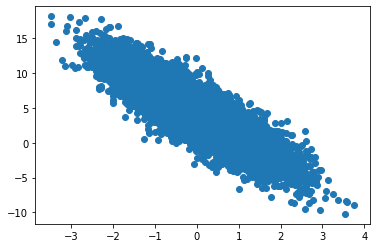

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

### Data Iterators:

We'll need the iterator to iterate through our data points. We'll also need to grab batches of k data points at a time to
shuffle our data. In MXNet, data iterators give us a nice set of utilities for fetching and manipulating data. In particular we'll work with the simple `DataLoader` class, that provides an intuitive way to use an `ArrayDataset` for training models.

In MXNet, we can load `X` and `y` into an ArrayDataset, by calling `gluon.data.ArrayDataset(X, y)`. It's ok for `X` to be a multi-dimensional input array (say, of images) and `y` to be just a one-dimensional array of labels. The one requirement is that they have equal lengths along the first axis, i.e., `len(X) == len(y)`.

Given an `ArrayDataset`, we can create a Dataloader which will grab random batches of data from an `ArrayDataset`. We'll need to specify 2 arguments. First, we'll need to say the `batch_size`, i.e., how many examples we need to grab at a time. Second, we'll need to specify whether or not to shuffle the data between iterations through the dataset.

In [40]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size = batch_size, shuffle = 1)

Once we've initialized our DataLoader(`train_data`), we can easily fetch batches by iterating over `train_data` just as if it were a python list. First, let's just grab one batch and break out of the loop.

In [41]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


#Note that here the input has a shape of 4*2 for a mini-batch of size 4.


[[-0.32397285 -0.2977011 ]
 [-1.2810212  -0.5196491 ]
 [-1.3990183  -1.8585796 ]
 [ 0.238371   -0.443693  ]]
<NDArray 4x2 @cpu(0)> 
[4.573771  3.4440975 7.6991553 6.02567  ]
<NDArray 4 @cpu(0)>


'\nNote that here the input has a shape of 4*2 for a mini-batch of size 4.\n'

Finally, if we pass over the entire dataset, and count the number of batches, we'll find that there are 2500 batches. We expect this because
our dataset has 10,000 examples and we configured the `DataLoader` with a batch size of 4.

In [42]:
for i, (data, label) in enumerate(train_data):
    pass

print(i + 1)

2500


### Model Parameters:

Now let's allocate some memory for our parameters and set there initial values. We'll want to initialize these parameters on the `model_ctx`.

In [43]:
w = nd.random_normal(shape = (num_inputs, num_outputs), ctx = model_ctx)
b = nd.random_normal(shape = num_outputs)
params = [w, b]
params
print(params[0].shape)
print(params[1].shape)

(2, 1)
(1,)


In the following cells, we are going to update these parameters to better fit our data. As discusssed in the theory section, this will involve
taking the gradient (a multi-dimensional derivative) of some <I>loss function</I> with respect to the parameters. We'll update each parameter in the
direction which minimises the loss. But first, let's allocate some memory for each gradient.

In [44]:
for param in params:
    param.attach_grad()

Now, we'll want to define our model. In this case, we'll be working with linear models, the simplest possible useful neural network. To calculate
the output of the linear model, we simply multiply a given input with model's weights(`w`), and add the offset `b`.

In [45]:
def net(X):
    return mx.nd.dot(X,w) + b

Now, we will be defining the cost function (MSE) in order to check the performance of our model.

In [46]:
def square_loss(y_hat, y):
    return nd.mean((y_hat - y)**2)

As we know from the previous discussions, we'll be updating the weights according to the eqn:
$$\begin{eqnarray}
        w_k &\to& w_k' &=& w_k - \frac {\eta}{m} \sum_j \frac {\partial C_{X_j}}{\partial w_k}\\
        b_l &\to& b_l' &=& b_l - \frac {\eta}{m} \sum_j \frac {\partial C_{X_j}}{\partial b_l}
\end{eqnarray}
$$

I will be solving the problem using two methods:
1. Hard coding the function to update the weights.
2. Using the MXNet in-built library function 'autograd'.

### 1. Updating weights with hardcoding:

As we know, the cost function that we are using to estimate the loss is the Mean Squared Error function:
$$
        l(\bar y, y) = \frac {1}{N} \sum_i(\bar y_i - y_i)^2
$$
        
Now, in our case $\bar y$ has the form: $\bar y = w_1x_1 + w_2x_2 + b$.

Thus our loss function becomes:
$$
       l = \frac{1}{N} \sum_i((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)^2
$$

In accordance with the weight updation rule, lets calculate the partial derivatives with respect to the weights and bias:
$$\begin{eqnarray}
       l' = \left[ \begin{matrix}
                       \frac {\partial l} {\partial w_1}\\
                       \frac {\partial l} {\partial w_2}\\
                       \frac {\partial l} {\partial b}
                   \end{matrix}
             \right]
          &=& \left[ \begin{matrix}
                          \frac{1}{N} \sum x_{1_i} \cdot 2((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)\\
                          \frac{1}{N} \sum x_{2_i} \cdot 2((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)\\
                          \frac{1}{N} \sum 1 \cdot 2((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)
                      \end{matrix}
              \right]\\
          &=& \left[ \begin{matrix}
                          \frac{1}{N} \sum 2x_{1_i} ((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)\\
                          \frac{1}{N} \sum 2x_{2_i} ((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)\\
                          \frac{1}{N} \sum  2((w_1x_{1_i} + w_2x_{2_i} + b) - y_i)
                      \end{matrix}
              \right]
\end{eqnarray}
$$

Now, once we have the gradients calculated we'll update the weights by subtracting the learning rate times the gradient value at the end of each epoch. This process will be repeated again and again unless the loss is minimised.

We can either hard code the gradient formulas into our code for each weight and bias. However, a smart way to go about it would be to use matrix multiplication so that the calculation can be done efficiently and with less lines of code.

As we have generated our data such that it has two independent variables. Let's call them $x_1$ & $x_2$.
Let's say we have a matrix of features as: 
$$
X = [x_1 \; x_2 \; 1] = \left[ \begin{matrix}
                                    x_{11} & x_{21} & 1\\
                                    x_{12} & x_{22} & 1\\
                                    x_{13} & x_{23} & 1\\
                                    x_{14} & x_{24} & 1
                                \end{matrix}
                         \right]
$$ 

Since we are generating mini-batches of size 4, hence the shape of this matrix would be 4\*3.

Also, we have an $\nabla error = (\bar y_i - y_i)$. For a mini-batch of size 4, this will output a matrix of 4\*1.

Thus if we take the dot product of the transpose of the input vector matrix as defined above and the error term we will get a matrix which will contain the derivatives:
$$
        derivs = \frac{2}{N} (X^T \cdot error), 
$$

where $X$ has a shape 4\*3, $error$ has a shape 4\*1, $N$ is the batch_size which is 4 and the output, $derivs$ will have a shape of 3\*1 containing partial derivatives for each of the weights and bias.
        
Note that I have appended a 1 in the input matrix $X$ to account for the bias term.

We'll be implementing this a little differently to account for the structure of the params.
Remember, the params is a list containing $w$ and $b$, hence we'll calculate the gradients for weights and bias separately as it will be easier to update the weights in this manner.

In [47]:
def update_weights(X, y, params, lr):
    #calculating the error term
    error = (y-net(X))
    
    #X contains [x1 x2]. Hence d_w will have the partial derivatives for w1 and w1 as [d_w1 d_w2].
    d_w = (2/batch_size)*mx.nd.dot(-X.T, error)
    
    #calculating the partial derivative for the bias.
    d_b = -2*nd.mean(error)
    
    derivs = [d_w, d_b]
    #updating the weights by subtracting the learning rate times the gradient
    for param, deriv in zip(params, derivs):
        #the '[:]' notation is a utility provided by MXNet which helps us update the values in the original variable.
        param[:] = param - lr*deriv

Now that we have all the pieces defined, we just need to wire them together by writing a training loop. First we'll define `epochs`, the 
number of passes to make over the dataset. Then for each pass we'll iterate through train data, grabbing batches of examples and their 
corresponding labels.

For each batch, we'll go through the following ritual:
1. Generate predictions ($\bar y$) and the loss by executing a forward pass through the network.
2. Calculate gradients and update the weights and bias by making a call to `update_weights`.

In [48]:
epochs = 10
learning_rate = 0.0001
num_batches = num_examples/batch_size
losses = []

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        output = net(data)
        loss = square_loss(output, label)
        update_weights(data, label, params, learning_rate)
        cumulative_loss += loss.asscalar()
    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)


Epoch 0, batch 2499. Mean loss: 29.295440874063967
Epoch 1, batch 2499. Mean loss: 10.714721115881204
Epoch 2, batch 2499. Mean loss: 3.9233919839300215
Epoch 3, batch 2499. Mean loss: 1.4409156888142227
Epoch 4, batch 2499. Mean loss: 0.533395497810468
Epoch 5, batch 2499. Mean loss: 0.20159582052256447
Epoch 6, batch 2499. Mean loss: 0.0802109730640892
Epoch 7, batch 2499. Mean loss: 0.03577849310876336
Epoch 8, batch 2499. Mean loss: 0.019532057394934237
Epoch 9, batch 2499. Mean loss: 0.013601328360976186


In [49]:
#Script to plot the losses over time
def plot(losses, X, sample_size = 100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
            net(X[:sample_size, :]).asnumpy(), 'or', label = 'Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
            real_fn(X[:sample_size, :]).asnumpy(), '*g', label = 'Real')
    fg2.legend()
    plt.show()

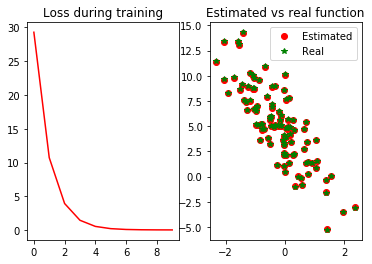

[
[[ 1.9825695]
 [-3.3635404]]
<NDArray 2x1 @cpu(0)>, 
[4.1782465]
<NDArray 1 @cpu(0)>]


In [50]:
#visualizing the loss and predictions
plot(losses, X)
print(params)

### 2. Updating weights using MXNet in-built library function `autograd()`:

Now we will be defining the stochastic gradient descent algorithm for updating the weights. As discussed earlier, we will first calculate the
gradient of the loss for a mini-batch with respect to the weights. Then, we'll update our parameters a small amount in the direction that reduces
the loss. The size of the step is determined by the `learning rate`, lr.

In [51]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr*param.grad

For each batch, we'll go through the following ritual:
1. Generate predictions (`yhat`) and the loss (`loss`) by executing a forward pass through the network.
2. Calculate gradients by making backwards pass through the network (`loss.backward`).
3. Update the model parameters by invoking our SGD optimizer.

In [52]:
#Re-initializing the parameters because they were already trained in the earlier training process
w[:] = nd.random_normal(shape = (num_inputs, num_outputs), ctx = model_ctx)
b[:] = nd.random_normal(shape = num_outputs)


losses_m = []


for e in range(epochs):
    cumulative_loss = 0
    #inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output_m = net(data)
            loss_m = square_loss(output_m, label)
        loss_m.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss_m.asscalar()
    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses_m.append(cumulative_loss/num_batches)

Epoch 0, batch 2499. Mean loss: 22.319529047417642
Epoch 1, batch 2499. Mean loss: 8.143442739459871
Epoch 2, batch 2499. Mean loss: 2.9753438791543245
Epoch 3, batch 2499. Mean loss: 1.091301687482372
Epoch 4, batch 2499. Mean loss: 0.4044055913154036
Epoch 5, batch 2499. Mean loss: 0.1539398751651868
Epoch 6, batch 2499. Mean loss: 0.06260263044489547
Epoch 7, batch 2499. Mean loss: 0.029294488492538222
Epoch 8, batch 2499. Mean loss: 0.017143411401711637
Epoch 9, batch 2499. Mean loss: 0.012711065220230376


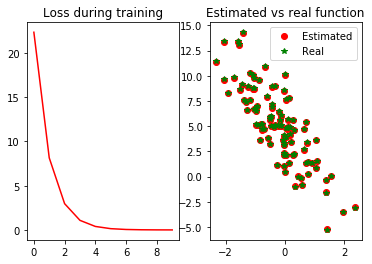

[
[[ 1.9786812]
 [-3.3756635]]
<NDArray 2x1 @cpu(0)>, 
[4.1779666]
<NDArray 1 @cpu(0)>]


In [53]:
plot(losses_m, X)
print(params)

As can be seen that both the algorithms give us similar results. I have solved the problem using both from `scratch algorithm` and `MXNet's autograd()` utility to demonstrate the usefulness of MXNet. As we go further we'll see how easy does MXNet make to implement deep neural networks from scratch.